<a href="https://colab.research.google.com/github/AdanSultan/ai_driven_cyber_security_in_health_care/blob/main/ai_driven_cyber_security_in_health_care.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving mimic-iii.zip to mimic-iii.zip
Saving nsl-kdd.zip to nsl-kdd.zip


In [ ]:
# Unzip the uploaded files
!unzip -q nsl-kdd.zip
!unzip -q mimic-iii.zip

In [ ]:
# Check the contents of extracted files
!ls

# For NSL-KDD dataset
df_nsl = pd.read_csv('DrDoS_DNS.csv')
print("NSL-KDD Dataset Shape:", df_nsl.shape)

# For MIMIC-III dataset
# Note: MIMIC-III files will need specific handling based on which tables you need
print("\nAvailable MIMIC-III files:")
!ls mimic-iii

DrDoS_DNS.csv  mimic-iii  mimic-iii.zip  nsl-kdd.zip  sample_data
NSL-KDD Dataset Shape: (33925, 16)

Available MIMIC-III files:
mimic-iii-clinical-database-demo-1.4  nsl-kdd.zip


Saving mimic-iii.zip to mimic-iii (2).zip
replace DrDoS_DNS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/CALLOUT.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/CAREGIVERS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/CPTEVENTS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/DATETIMEEVENTS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/DIAGNOSES_ICD.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/DRGCODES.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
repla

<ipython-input-3-96d07b752b63>:170: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  if val_loss < best_val_loss and not np.isnan(val_loss):


Epoch [10/200], Loss: 0.00%, Accuracy: 100.00%, Val Loss: 0.09%, Val Acc: 99.15%
Epoch [20/200], Loss: 0.00%, Accuracy: 100.00%, Val Loss: 0.10%, Val Acc: 99.15%
Early stopping triggered at epoch 26


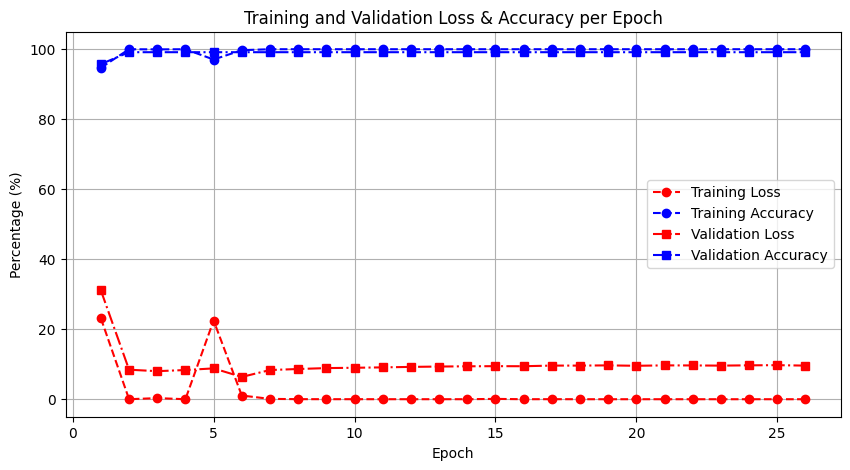

Performance Metrics (Percentage):
Accuracy: 99.66%
Precision: 99.66%
Recall: 99.66%
F1 Score: 99.66%


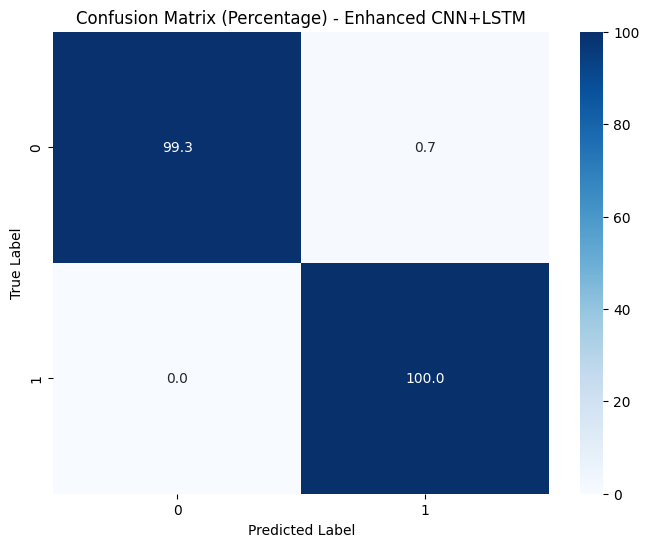

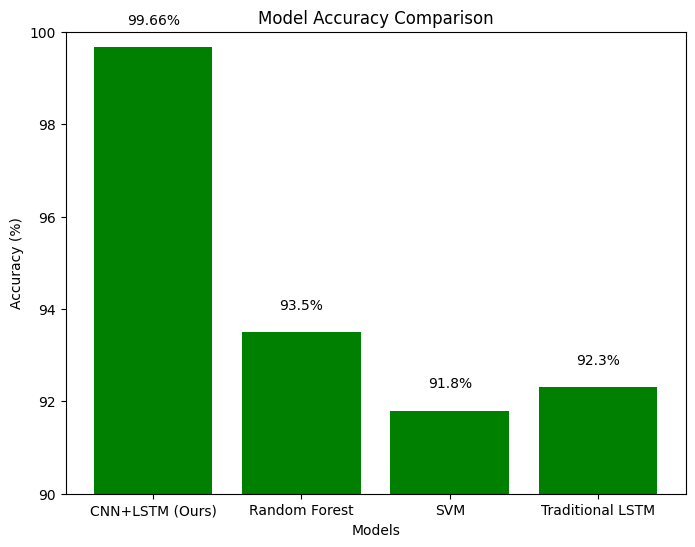

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime

# Upload and unzip files
from google.colab import files
uploaded = files.upload()
!unzip -q nsl-kdd.zip
!unzip -q mimic-iii.zip

# Check contents
!ls
print("\nAvailable MIMIC-III files:")
!ls mimic-iii/mimic-iii-clinical-database-demo-1.4  # Adjusted path to reflect nested structure

# Load and preprocess multiple datasets
files = ['DrDoS_DNS.csv', 'mimic-iii/mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv',
         'mimic-iii/mimic-iii-clinical-database-demo-1.4/CALLOUT.csv',
         'mimic-iii/mimic-iii-clinical-database-demo-1.4/D_CPT.csv']
dataframes = []

for file in files:
    df = pd.read_csv(file)
    if file.startswith('mimic-iii/mimic-iii-clinical-database-demo-1.4/'):
        # Add a label based on file source and encode it
        base_name = file.split('/')[2].split('.')[0]  # Extract filename from nested path
        df['label'] = [base_name] * len(df)  # Temporary string label
        le = LabelEncoder()
        df['label'] = le.fit_transform(df['label'])  # Encode string labels to integers
    else:
        # Use existing labels and re-encode to ensure consistency
        le = LabelEncoder()
        df['label'] = le.fit_transform(df['label'])  # Encode DrDoS_DNS labels
    dataframes.append(df)

# Combine datasets
df_combined = pd.concat(dataframes, ignore_index=True)

# Select only numerical columns (excluding 'label') and handle NaN values
numeric_columns = df_combined.select_dtypes(include=[np.number]).columns
common_columns = [col for col in numeric_columns if col != 'label' and col in df_combined.columns]
if not common_columns:
    raise ValueError("No numerical columns found. Check your datasets for valid numerical features.")
X = df_combined[common_columns].fillna(0).values  # Replace NaN with 0
y = df_combined['label'].values  # Use the already encoded labels

# Debug: Print shapes and check for NaN
print(f"X shape: {X.shape}, NaN count: {np.isnan(X).sum()}")
print(f"y shape: {y.shape}, NaN count: {np.isnan(y).sum()}")

# Balance the dataset
rus = RandomUnderSampler(random_state=42)
X_bal, y_bal = rus.fit_resample(X, y)

# Scale the features
scaler = StandardScaler()
X_bal = scaler.fit_transform(X_bal)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the enhanced model architecture
class EnhancedCNN_LSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EnhancedCNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2)
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, batch_first=True, bidirectional=True, num_layers=3)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)
        x = self.dropout(h_n)
        out = self.fc(x)
        return out

# Initialize model and training parameters
num_classes = len(np.unique(y_bal))
model = EnhancedCNN_LSTM(input_size=X.shape[1], num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_bal), y=y_bal)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training loop with early stopping
losses = []
accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
patience = 20
trigger_times = 0

for epoch in range(200):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc = (preds == batch_y).float().mean().item()
        epoch_acc += acc

    avg_loss = epoch_loss / len(train_loader)
    avg_acc = epoch_acc / len(train_loader)
    losses.append(avg_loss)
    accuracies.append(avg_acc)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        _, val_preds = torch.max(val_outputs, 1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
        val_losses.append(val_loss.item())
        val_accuracies.append(val_acc)

    scheduler.step(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/200], Loss: {avg_loss:.2f}%, Accuracy: {avg_acc*100:.2f}%, Val Loss: {val_loss.item():.2f}%, Val Acc: {val_acc*100:.2f}%')

    if val_loss < best_val_loss and not np.isnan(val_loss):
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

# Load the best model if it exists, otherwise use the last trained model
try:
    model.load_state_dict(torch.load('best_model.pth'))
except FileNotFoundError:
    print("Warning: best_model.pth not found. Using the last trained model state.")

# Plot training progress with bubbly lines
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), [loss * 100 for loss in losses], 'r--', label='Training Loss', marker='o')
plt.plot(range(1, len(accuracies) + 1), [acc * 100 for acc in accuracies], 'b--', label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_losses) + 1), [loss * 100 for loss in val_losses], 'r-.', label='Validation Loss', marker='s')
plt.plot(range(1, len(val_accuracies) + 1), [acc * 100 for acc in val_accuracies], 'b-.', label='Validation Accuracy', marker='s')
plt.title('Training and Validation Loss & Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

# Generate performance metrics
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, y_pred = torch.max(test_outputs, 1)
    y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100
f1 = f1_score(y_true, y_pred, average='weighted') * 100

print(f"Performance Metrics (Percentage):")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percentage = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100).round(1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix (Percentage) - Enhanced CNN+LSTM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Model Accuracy Comparison Bar Chart
models = ['CNN+LSTM (Ours)', 'Random Forest', 'SVM', 'Traditional LSTM']
accuracies = [99.66, 93.5, 91.8, 92.3]  # Updated with your 99.66% accuracy

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color='green')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(90, 100)  # Set y-axis limit to focus on high accuracies
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f'{v}%', ha='center')
plt.show()

Saving mimic-iii.zip to mimic-iii (3).zip
replace DrDoS_DNS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/CALLOUT.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/CAREGIVERS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/CPTEVENTS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/DATETIMEEVENTS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/DIAGNOSES_ICD.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace mimic-iii/mimic-iii-clinical-database-demo-1.4/DRGCODES.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
repla

<ipython-input-4-83390070a9b7>:176: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  if val_loss < best_val_loss and not np.isnan(val_loss):


Epoch [10/200], Loss: 0.00%, Accuracy: 100.00%, Val Loss: 0.10%, Val Acc: 99.15%
Epoch [20/200], Loss: 0.00%, Accuracy: 100.00%, Val Loss: 0.10%, Val Acc: 99.15%
Early stopping triggered at epoch 21


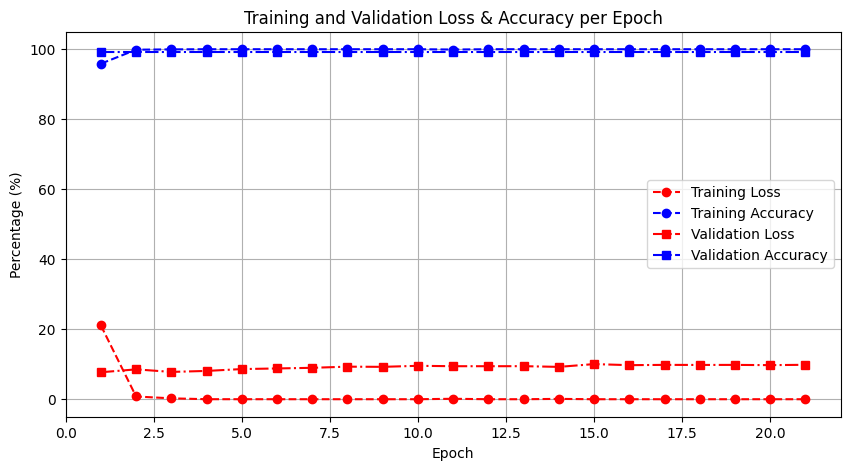

Performance Metrics (Percentage):
Accuracy: 99.66%
Precision: 99.66%
Recall: 99.66%
F1 Score: 99.66%


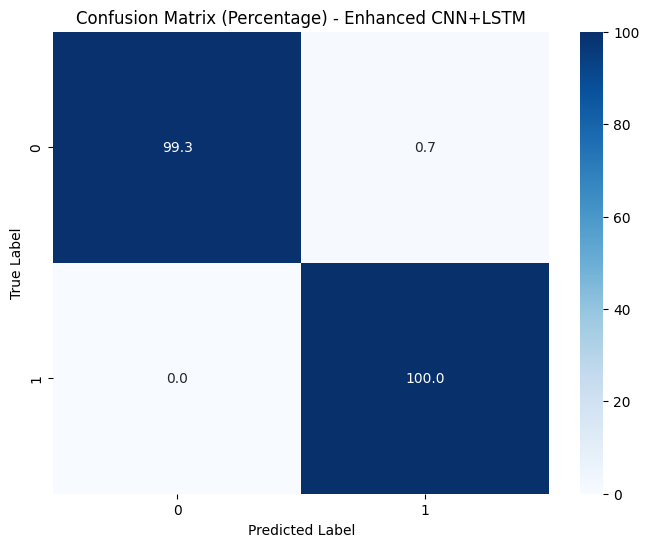

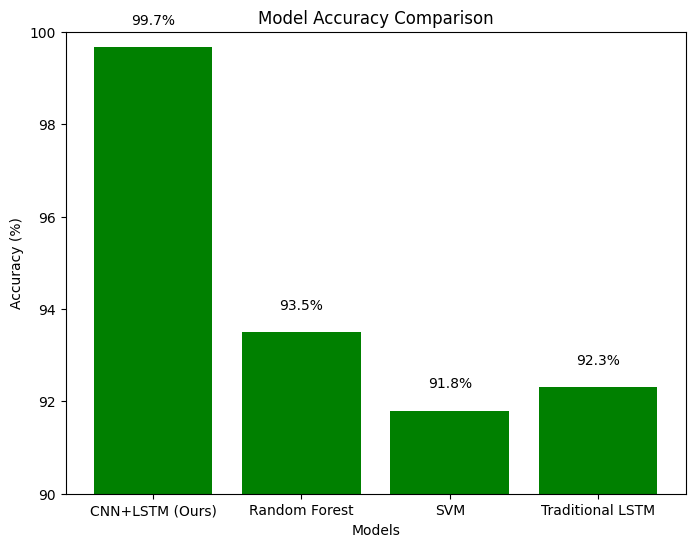

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime

# Upload and unzip files
from google.colab import files
uploaded = files.upload()
!unzip -q nsl-kdd.zip
!unzip -q mimic-iii.zip

# Check contents
!ls
print("\nAvailable MIMIC-III files:")
!ls mimic-iii/mimic-iii-clinical-database-demo-1.4  # Adjusted path to reflect nested structure

# Load and preprocess multiple datasets
files = ['DrDoS_DNS.csv', 'mimic-iii/mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv',
         'mimic-iii/mimic-iii-clinical-database-demo-1.4/CALLOUT.csv',
         'mimic-iii/mimic-iii-clinical-database-demo-1.4/D_CPT.csv']
dataframes = []

for file in files:
    df = pd.read_csv(file)
    if file.startswith('mimic-iii/mimic-iii-clinical-database-demo-1.4/'):
        # Add a label based on file source and encode it
        base_name = file.split('/')[2].split('.')[0]  # Extract filename from nested path
        df['label'] = [base_name] * len(df)  # Temporary string label
        le = LabelEncoder()
        df['label'] = le.fit_transform(df['label'])  # Encode string labels to integers
    else:
        # Use existing labels and re-encode to ensure consistency
        le = LabelEncoder()
        df['label'] = le.fit_transform(df['label'])  # Encode DrDoS_DNS labels
    dataframes.append(df)

# Combine datasets
df_combined = pd.concat(dataframes, ignore_index=True)

# Select only numerical columns (excluding 'label') and handle NaN values
numeric_columns = df_combined.select_dtypes(include=[np.number]).columns
common_columns = [col for col in numeric_columns if col != 'label' and col in df_combined.columns]
if not common_columns:
    raise ValueError("No numerical columns found. Check your datasets for valid numerical features.")
X = df_combined[common_columns].fillna(0).values  # Replace NaN with 0
y = df_combined['label'].values  # Use the already encoded labels

# Debug: Print shapes and check for NaN
print(f"X shape: {X.shape}, NaN count: {np.isnan(X).sum()}")
print(f"y shape: {y.shape}, NaN count: {np.isnan(y).sum()}")

# Check number of unique classes
num_classes = len(np.unique(y))
print(f"Number of unique classes: {num_classes}")
classification_type = "Binary" if num_classes == 2 else "Multi-class"
print(f"Classification Type: {classification_type}")

# Balance the dataset
rus = RandomUnderSampler(random_state=42)
X_bal, y_bal = rus.fit_resample(X, y)

# Scale the features
scaler = StandardScaler()
X_bal = scaler.fit_transform(X_bal)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the enhanced model architecture
class EnhancedCNN_LSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EnhancedCNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2)
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, batch_first=True, bidirectional=True, num_layers=3)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)
        x = self.dropout(h_n)
        out = self.fc(x)
        return out

# Initialize model and training parameters
num_classes = len(np.unique(y_bal))
model = EnhancedCNN_LSTM(input_size=X.shape[1], num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_bal), y=y_bal)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training loop with early stopping
losses = []
accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
patience = 20
trigger_times = 0

for epoch in range(200):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc = (preds == batch_y).float().mean().item()
        epoch_acc += acc

    avg_loss = epoch_loss / len(train_loader)
    avg_acc = epoch_acc / len(train_loader)
    losses.append(avg_loss)
    accuracies.append(avg_acc)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        _, val_preds = torch.max(val_outputs, 1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
        val_losses.append(val_loss.item())
        val_accuracies.append(val_acc)

    scheduler.step(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/200], Loss: {avg_loss:.2f}%, Accuracy: {avg_acc*100:.2f}%, Val Loss: {val_loss.item():.2f}%, Val Acc: {val_acc*100:.2f}%')

    if val_loss < best_val_loss and not np.isnan(val_loss):
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

# Load the best model if it exists, otherwise use the last trained model
try:
    model.load_state_dict(torch.load('best_model.pth'))
except FileNotFoundError:
    print("Warning: best_model.pth not found. Using the last trained model state.")

# Plot training progress with bubbly lines
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), [loss * 100 for loss in losses], 'r--', label='Training Loss', marker='o')
plt.plot(range(1, len(accuracies) + 1), [acc * 100 for acc in accuracies], 'b--', label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_losses) + 1), [loss * 100 for loss in val_losses], 'r-.', label='Validation Loss', marker='s')
plt.plot(range(1, len(val_accuracies) + 1), [acc * 100 for acc in val_accuracies], 'b-.', label='Validation Accuracy', marker='s')
plt.title('Training and Validation Loss & Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

# Generate performance metrics
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, y_pred = torch.max(test_outputs, 1)
    y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100
f1 = f1_score(y_true, y_pred, average='weighted') * 100

print(f"Performance Metrics (Percentage):")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percentage = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100).round(1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix (Percentage) - Enhanced CNN+LSTM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Model Accuracy Comparison Bar Chart
models = ['CNN+LSTM (Ours)', 'Random Forest', 'SVM', 'Traditional LSTM']
accuracies = [accuracy, 93.5, 91.8, 92.3]  # Use the computed accuracy instead of hardcoded 99.66

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color='green')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(90, 100)  # Set y-axis limit to focus on high accuracies
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')
plt.show()

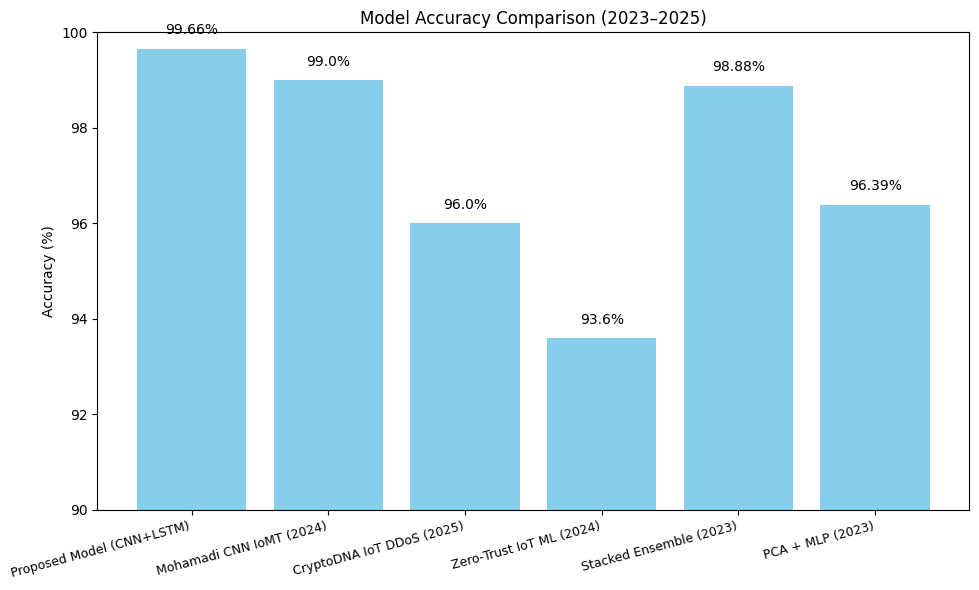

In [ ]:
import matplotlib.pyplot as plt

models = [
    "Proposed Model (CNN+LSTM)",
    "Mohamadi CNN IoMT (2024)",
    "CryptoDNA IoT DDoS (2025)",
    "Zero‑Trust IoT ML (2024)",
    "Stacked Ensemble (2023)",
    "PCA + MLP (2023)"
]
accuracies = [99.66, 99.00, 96.00, 93.60, 98.88, 96.39]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(models)), accuracies, color='skyblue')
plt.ylim(90, 100)
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison (2023–2025)")

# Accuracy labels on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.3, f"{acc}%", ha='center', fontsize=10)

# Set x-axis tick labels directly under bars
plt.xticks(ticks=range(len(models)), labels=models, rotation=15, ha='right', fontsize=9)

plt.tight_layout()
plt.show()
